In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd

# Load the smoking rate data
smoking_data = pd.read_csv('/content/drive/MyDrive/smokingdata/API_SH.PRV.SMOK_DS2_en_csv_v2_5874205.csv', skiprows=4)

# Load the GDP growth rate data from the CSV file
gdp_growth_data_csv = pd.read_csv('/content/drive/MyDrive/smokingdata/imf-dm-export-20230923.csv')

# Determine overlapping years between the two datasets
smoking_years = set(smoking_data.columns[4:-1])
gdp_growth_years = set(gdp_growth_data_csv.columns[1:])
overlapping_years = sorted(list(smoking_years.intersection(gdp_growth_years)))

# Filter the relevant columns from both datasets
smoking_data_filtered = smoking_data[["Country Name"] + overlapping_years]
gdp_growth_data_filtered = gdp_growth_data_csv[["Real GDP growth (Annual percent change)"] + overlapping_years]

# Rename columns for merging
smoking_data_filtered = smoking_data_filtered.rename(columns={"Country Name": "Country"})
gdp_growth_data_filtered = gdp_growth_data_filtered.rename(columns={"Real GDP growth (Annual percent change)": "Country"})

# Merge the datasets on country name
merged_data = pd.merge(smoking_data_filtered, gdp_growth_data_filtered, on="Country", suffixes=('_smoking', '_gdp'))

# Replace "no data" with NaN and convert relevant columns to float
merged_data.replace("no data", float('nan'), inplace=True)
for year in overlapping_years:
    merged_data[f"{year}_smoking"] = merged_data[f"{year}_smoking"].astype(float)
    merged_data[f"{year}_gdp"] = merged_data[f"{year}_gdp"].astype(float)

# Melt and merge to get the final formatted dataset
smoking_melted = merged_data.melt(id_vars=['Country'], value_vars=[f"{year}_smoking" for year in overlapping_years],
                                  var_name='Year', value_name='Smoking Rate')
gdp_melted = merged_data.melt(id_vars=['Country'], value_vars=[f"{year}_gdp" for year in overlapping_years],
                              var_name='Year', value_name='GDP Growth Rate')

smoking_melted['Year'] = smoking_melted['Year'].str.split('_').str[0]
gdp_melted['Year'] = gdp_melted['Year'].str.split('_').str[0]

final_data = pd.merge(smoking_melted, gdp_melted, on=['Country', 'Year'])


In [5]:
import statsmodels.api as sm

cleaned_data = final_data.dropna(subset=['Smoking Rate', 'GDP Growth Rate'])

X = cleaned_data['Smoking Rate']
y = cleaned_data['GDP Growth Rate']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        GDP Growth Rate   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.716
Date:                Sat, 23 Sep 2023   Prob (F-statistic):             0.0542
Time:                        20:47:58   Log-Likelihood:                -3293.7
No. Observations:                1077   AIC:                             6591.
Df Residuals:                    1075   BIC:                             6601.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.9798      0.370      5.347   

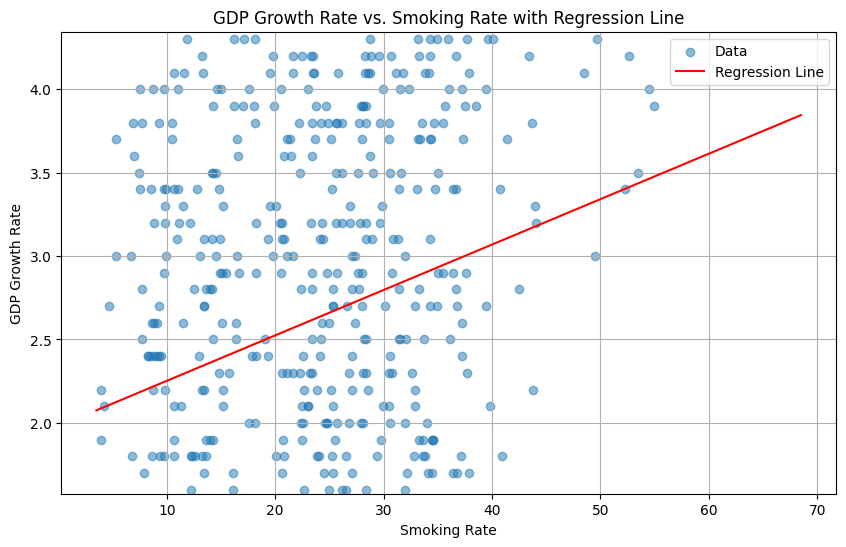

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Determine the range of the regression line values
ys_min = ys.min()
ys_max = ys.max()


padding = 0.5
y_axis_limits = (ys_min - padding, ys_max + padding)


plt.figure(figsize=(10, 6))
plt.scatter(cleaned_data['Smoking Rate'], cleaned_data['GDP Growth Rate'], alpha=0.5, label='Data')
plt.plot(xs, ys, color='red', label='Regression Line')

plt.xlabel('Smoking Rate')
plt.ylabel('GDP Growth Rate')
plt.title('GDP Growth Rate vs. Smoking Rate with Regression Line')
plt.ylim(y_axis_limits)
plt.legend()
plt.grid(True)

plt.show()


# Predict US GDP Growth rate if smoking rate was 75%

In [14]:
# Given smoking rate
smoking_rate_2022 = 75

# Predict the GDP growth rate using the model coefficients
predicted_gdp_growth_2022 = model.params[0] + model.params[1] * smoking_rate_2022

# Compute the difference between the predicted and actual growth rate
actual_gdp_growth_2022 = final_data[(final_data['Country'] == 'United States') & (final_data['Year'] == '2022')]['GDP Growth Rate'].values[0]
difference = predicted_gdp_growth_2022 - actual_gdp_growth_2022
difference


print(f'The GDP Growth rate of the US if the smoking rate was 75%:  {predicted_gdp_growth_2022} %')

print(f'Difference to actual:  {difference} %')


The GDP Growth rate of the US if the smoking rate was 75%:  4.022037078337345 %
Difference to actual:  1.9220370783373446 %
